# Download the data from [hydroshed](https://hydrosheds.cr.usgs.gov/datadownload.php)
## This script download the data from the HydroSHEDS website and merge them togehter based into a signle file

In [1]:
# import necessary packages
from pysheds.grid import Grid
import numpy as np
import os
import glob
import requests
from zipfile import ZipFile
from osgeo import gdal # or instead only import gdal
import matplotlib.pyplot as plt
# set the font and font size for plots
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 16})


# partly based on https://stackabuse.com/download-files-with-python/
# specify the directory where the data will be downloaded to
des_loc = '/Users/shg096/Desktop/DEM_downloads/'

# List of the zip file to be downloaded
# The link to the file can be found by right clicking on the file and copy the link here
minlat, maxlat = 40, 50
minlon, maxlon = 60, 85
latitudes = np.arange(minlat,maxlat+1,5)
longitudes = np.arange(minlon,maxlon+1,5)
urls_con_dem = []
urls_dir = []
for lat in latitudes:
    for lon in longitudes:
        urls_con_dem += ['https://edcintl.cr.usgs.gov/downloads/sciweb1/shared/hydrosheds/sa_con_3s_bil/NA/n'+str(lat)+'w'+"{0:0=3d}".format(lon)+'_con_bil.zip']
        urls_dir += ['https://edcintl.cr.usgs.gov/downloads/sciweb1/shared/hydrosheds/sa_dir_3s_zip_bil/NA/n'+str(lat)+'w'+"{0:0=3d}".format(lon)+'_dir_bil.zip']


# creating the source destination folder if does not exists
if not os.path.exists(des_loc):
    os.makedirs(des_loc)
    
# create the urls from conditioned DEM and direction
urls = urls_con_dem + urls_dir

# loop to download the data
for url in urls:
    name = url.split('/')[-1] # get the name of the zip file at the end of the url to download
    r = requests.get(url) # download the URL
    # print the specification of the download 
    print(r.status_code, r.headers['content-type'], r.encoding)
    # if download successful the statuse code is 200 then save the file, else print what was not downloaded
    if r.status_code == 200:
        print('download was successful for '+url)
        with open(des_loc+name, 'wb') as f:
            f.write(r.content)
    else:
        print('download was not successful for '+url)

200 application/zip None
download was successful for https://edcintl.cr.usgs.gov/downloads/sciweb1/shared/hydrosheds/sa_con_3s_bil/NA/n40w060_con_bil.zip
200 application/zip None
download was successful for https://edcintl.cr.usgs.gov/downloads/sciweb1/shared/hydrosheds/sa_con_3s_bil/NA/n40w065_con_bil.zip
200 application/zip None
download was successful for https://edcintl.cr.usgs.gov/downloads/sciweb1/shared/hydrosheds/sa_con_3s_bil/NA/n40w070_con_bil.zip
200 application/zip None
download was successful for https://edcintl.cr.usgs.gov/downloads/sciweb1/shared/hydrosheds/sa_con_3s_bil/NA/n40w075_con_bil.zip
200 application/zip None
download was successful for https://edcintl.cr.usgs.gov/downloads/sciweb1/shared/hydrosheds/sa_con_3s_bil/NA/n40w080_con_bil.zip
200 application/zip None
download was successful for https://edcintl.cr.usgs.gov/downloads/sciweb1/shared/hydrosheds/sa_con_3s_bil/NA/n40w085_con_bil.zip
200 application/zip None
download was successful for https://edcintl.cr.usgs

## Unzip the zip files

In [2]:
name_zips = glob.glob(des_loc+'*.zip')  # getting the name of the all the downloaded zip file in one directory
# loop over the zip file names and unzip them
for name_zip in name_zips:
    with ZipFile(name_zip, 'r') as zipObj:
        # Extract all the contents of zip file in different directory
        folder_name = name_zip[:-4] # removing the zip extension (.zip)
        zipObj.extractall(folder_name)

## Merging DEMs into one DEM file

In [3]:
# partly based on https://www.neonscience.org/merge-lidar-geotiff-py
names = glob.glob(des_loc+'*con*/*.bil') # get the name of the bil files for conditioned DEM
string_of_names = " ".join(names) # make a string of them
print(string_of_names) # print the string for checking
# create the command for gdal_merge, note the the gdal_merge is located in dgal directory for ease of use
# for the ease of the user the gdal_merge is stored in a subfolder gdal
command = 'python gdal/gdal_merge.py -o '+des_loc+'merged_DEM.tif '+ string_of_names
print(command) # print the command to check
os.system(command) # execute the command

/Users/shg096/Desktop/DEM_downloads/n45w080_con_bil/n45w080_con.bil /Users/shg096/Desktop/DEM_downloads/n40w075_con_bil/n40w075_con.bil /Users/shg096/Desktop/DEM_downloads/n40w065_con_bil/n40w065_con.bil /Users/shg096/Desktop/DEM_downloads/n50w080_con_bil/n50w080_con.bil /Users/shg096/Desktop/DEM_downloads/n50w065_con_bil/n50w065_con.bil /Users/shg096/Desktop/DEM_downloads/n50w075_con_bil/n50w075_con.bil /Users/shg096/Desktop/DEM_downloads/n40w080_con_bil/n40w080_con.bil /Users/shg096/Desktop/DEM_downloads/n45w075_con_bil/n45w075_con.bil /Users/shg096/Desktop/DEM_downloads/n45w065_con_bil/n45w065_con.bil /Users/shg096/Desktop/DEM_downloads/n45w060_con_bil/n45w060_con.bil /Users/shg096/Desktop/DEM_downloads/n45w070_con_bil/n45w070_con.bil /Users/shg096/Desktop/DEM_downloads/n40w085_con_bil/n40w085_con.bil /Users/shg096/Desktop/DEM_downloads/n50w070_con_bil/n50w070_con.bil /Users/shg096/Desktop/DEM_downloads/n50w060_con_bil/n50w060_con.bil /Users/shg096/Desktop/DEM_downloads/n50w085_con_

0

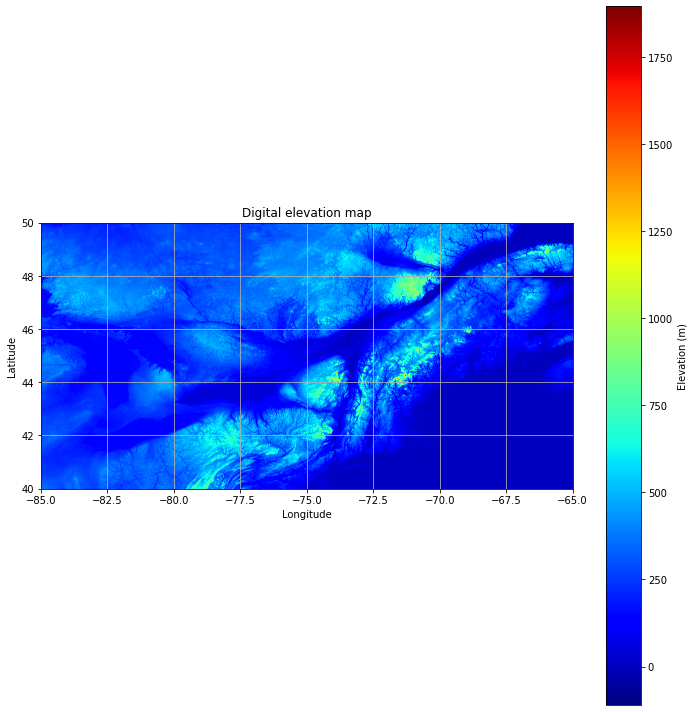

In [4]:
grid = Grid.from_raster(des_loc+'merged_DEM.tif', data_name='dem')

ID = np.where(grid.dem!=0) # the missing values is set to 0 removing them from min and max for colorbar
plt.figure(figsize = (10,10))
plt.imshow(grid.dem.astype(float), extent=grid.extent, cmap='jet', zorder=1,
           vmin=np.min(grid.dem[ID]), vmax=np.max(grid.dem[ID]))
plt.colorbar(label='Elevation (m)') # creating the colorbar and its name and unit
plt.grid(zorder=0) # creating the grid on the map
plt.title('Digital elevation map') # creating title
plt.xlabel('Longitude') #xlable which is long
plt.ylabel('Latitude') #ylable which is lat
plt.tight_layout()

In [5]:
# partly based on https://www.neonscience.org/merge-lidar-geotiff-py
names = glob.glob(des_loc+'*dir*/*.bil') # get the name of the bil files for conditioned DEM
string_of_names = " ".join(names) # make a string of them
print(string_of_names) # print the string for checking
# create the command for gdal_merge, note the the gdal_merge is located in dgal directory for ease of use
# for the ease of the user the gdal_merge is stored in a subfolder gdal
command = 'python gdal/gdal_merge.py -o '+des_loc+'merged_dir.tif '+ string_of_names
print(command) # print the command to check
os.system(command) # execute the command

/Users/shg096/Desktop/DEM_downloads/n45w085_dir_bil/n45w085_dir.bil /Users/shg096/Desktop/DEM_downloads/n40w060_dir_bil/n40w060_dir.bil /Users/shg096/Desktop/DEM_downloads/n40w070_dir_bil/n40w070_dir.bil /Users/shg096/Desktop/DEM_downloads/n50w085_dir_bil/n50w085_dir.bil /Users/shg096/Desktop/DEM_downloads/n50w070_dir_bil/n50w070_dir.bil /Users/shg096/Desktop/DEM_downloads/n50w060_dir_bil/n50w060_dir.bil /Users/shg096/Desktop/DEM_downloads/n40w085_dir_bil/n40w085_dir.bil /Users/shg096/Desktop/DEM_downloads/n45w060_dir_bil/n45w060_dir.bil /Users/shg096/Desktop/DEM_downloads/n45w070_dir_bil/n45w070_dir.bil /Users/shg096/Desktop/DEM_downloads/n45w075_dir_bil/n45w075_dir.bil /Users/shg096/Desktop/DEM_downloads/n45w065_dir_bil/n45w065_dir.bil /Users/shg096/Desktop/DEM_downloads/n40w080_dir_bil/n40w080_dir.bil /Users/shg096/Desktop/DEM_downloads/n50w065_dir_bil/n50w065_dir.bil /Users/shg096/Desktop/DEM_downloads/n50w075_dir_bil/n50w075_dir.bil /Users/shg096/Desktop/DEM_downloads/n50w080_dir_

0

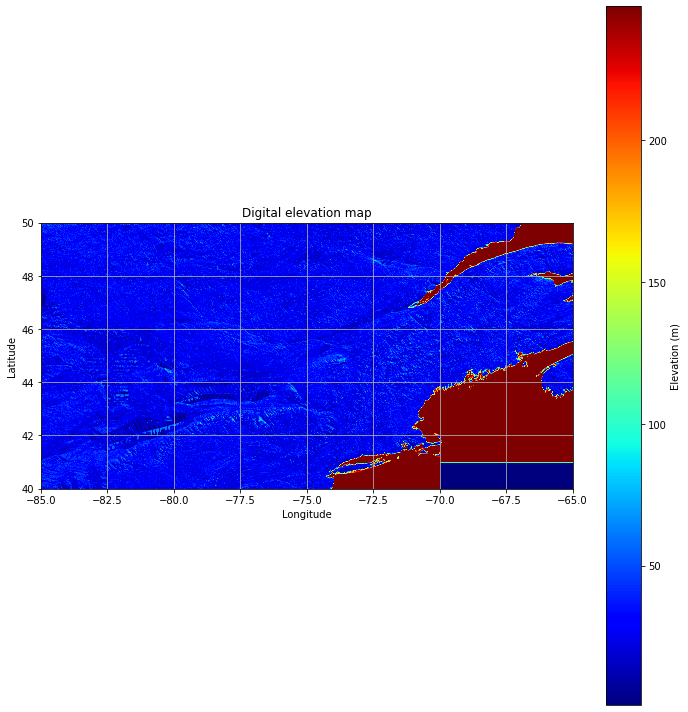

In [6]:
grid = Grid.from_raster(des_loc+'merged_dir.tif', data_name='dem')

ID = np.where(grid.dem!=0) # the missing values is set to 0 removing them from min and max for colorbar
plt.figure(figsize = (10,10))
plt.imshow(grid.dem.astype(float), extent=grid.extent, cmap='jet', zorder=1,
           vmin=np.min(grid.dem[ID]), vmax=np.max(grid.dem[ID]))
plt.colorbar(label='Elevation (m)') # creating the colorbar and its name and unit
plt.grid(zorder=0) # creating the grid on the map
plt.title('Digital elevation map') # creating title
plt.xlabel('Longitude') #xlable which is long
plt.ylabel('Latitude') #ylable which is lat
plt.tight_layout()